<a href="https://colab.research.google.com/github/Bhavay-2001/SAM-2/blob/main/SAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything Model 2

SAM 2 by Meta is an object segmentation model for both images and videos. It's unified model architecture excels in handling visual data and supports real-time processing and zero-shot generalization.

## Model Architecture

### Core Components
* Image and Video Encoder: Utilizes a transformer-based architecture to extract high-level features from both images and video frames. This component is responsible for understanding the visual content at each timestep.
* Prompt Encoder: Processes user-provided prompts (points, boxes, masks) to guide the segmentation task. This allows SAM 2 to adapt to user input and target specific objects within a scene.
* Memory Mechanism: Includes a memory encoder, memory bank, and memory attention module. These components collectively store and utilize information from past frames, enabling the model to maintain consistent object tracking over time. It also handles the occlusions in the data.
* Mask Decoder: Generates the final segmentation masks based on the encoded image features and prompts. In video, it also uses memory context to ensure accurate tracking across frames.

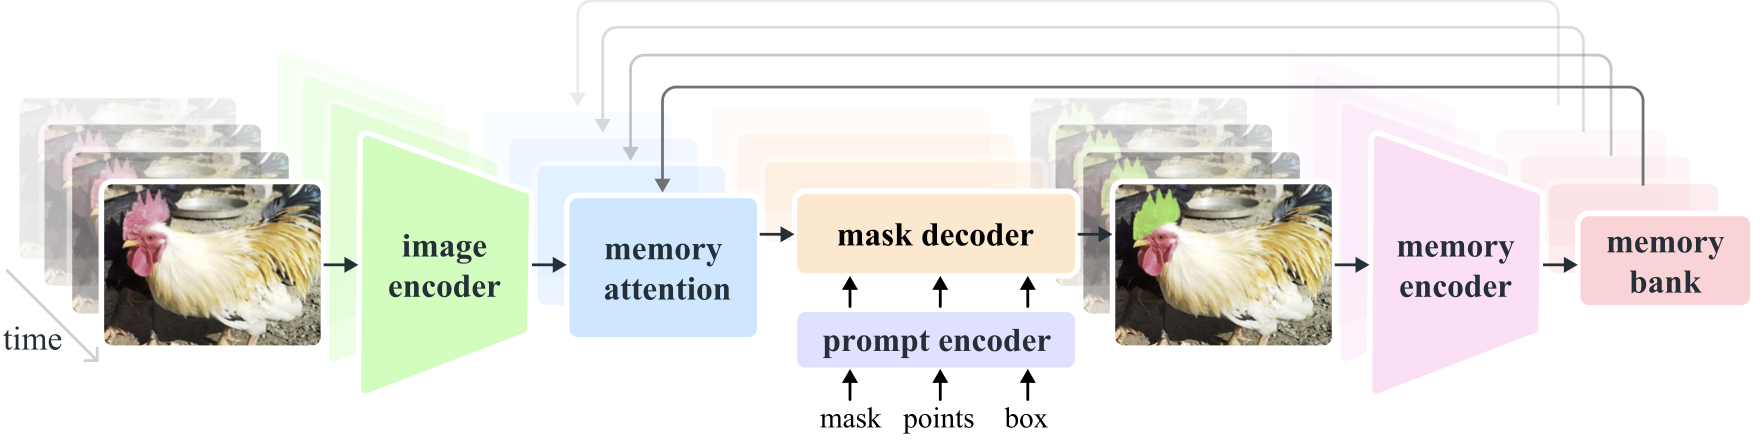


## Installing necessary dependencies

In [ ]:
!pip install supervision

In [1]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2
!pip install -e .
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 510 (delta 132), reused 74 (delta 50), pack-reused 312 (from 1)
Receiving objects: 100% (510/510), 78.53 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/segment-anything-2
Obtaining file:///content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvid

running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:499: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:418: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:428: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.2
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'sam2._C' extension
creating build
creating build/temp.linux-x86_64-cpython-310
creating build

## Installing SAM2 model:

SAM 2 offers four distinct model sizes, each tailored to specific computational constraints and performance requirements:

* [sam2_hiera_tiny.pt](https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt)
* [sam2_hiera_small.pt](https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt)
* [sam2_hiera_base_plus.pt](https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt)
* [sam2_hiera_large.pt](https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt)

In [3]:
!pwd
%cd segment-anything-2

/content
/content/segment-anything-2


In [2]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

## Setting up model configuration

In [5]:
import torch
from sam2.build_sam import build_sam2_video_predictor

CHECKPOINT = "sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [7]:
inference_state = sam2_model.init_state('/content/video_frames')

frame loading (JPEG): 100%|██████████| 233/233 [00:07<00:00, 29.90it/s]


## Extracting frames from a video

In [6]:
import supervision as sv

frames_generator = sv.get_video_frames_generator('/content/videoplayback_trimmed.mp4')
sink = sv.ImageSink(
    target_dir_path='/content/video_frames',
    image_name_pattern="{:05d}.jpeg")

with sink:
    for frame in frames_generator:
        sink.save_image(frame)

In [8]:
import matplotlib.pyplot as plt

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

## Segmenting and tracking multiple objects in a video

## Javeline

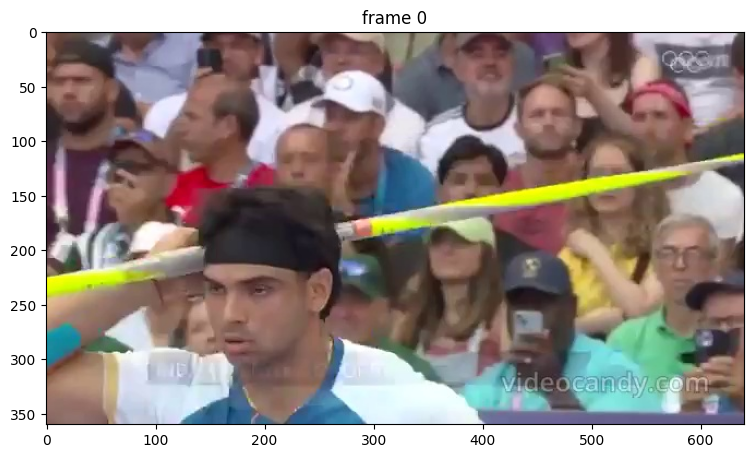

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

video_dir = '/content/video_frames'
frame_names = sorted(os.listdir(video_dir))
ann_frame_idx = 0

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))

In [12]:
import numpy as np

points = np.array([[300, 180]], dtype=np.float32)
labels = np.array([1])
frame_idx = 0
tracker_id = 1

frame_ids, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id,
    points=points,
    labels=labels,
)

print(frame_ids)
print(object_ids)
print(mask_logits)

0
[1]
tensor([[[[-12.5868, -12.6929, -13.1173,  ..., -12.6869, -13.1485, -13.2639],
          [-13.3867, -13.2748, -12.8274,  ..., -12.6647, -12.2939, -12.2013],
          [-13.5325, -13.2972, -12.3564,  ..., -12.8249, -12.0831, -11.8977],
          ...,
          [ -9.8386,  -9.7236,  -9.2640,  ..., -15.4029, -14.9207, -14.8001],
          [ -9.4261,  -9.3515,  -9.0532,  ..., -14.8759, -14.3945, -14.2741],
          [ -9.1236,  -9.0869,  -8.9399,  ..., -13.8231, -13.2461, -13.1018]]]],
       device='cuda:0')



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


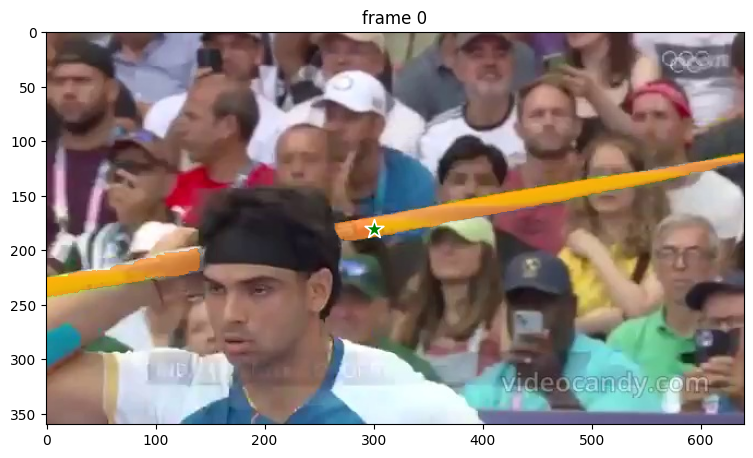

In [13]:
from PIL import Image
import os

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=object_ids[0])

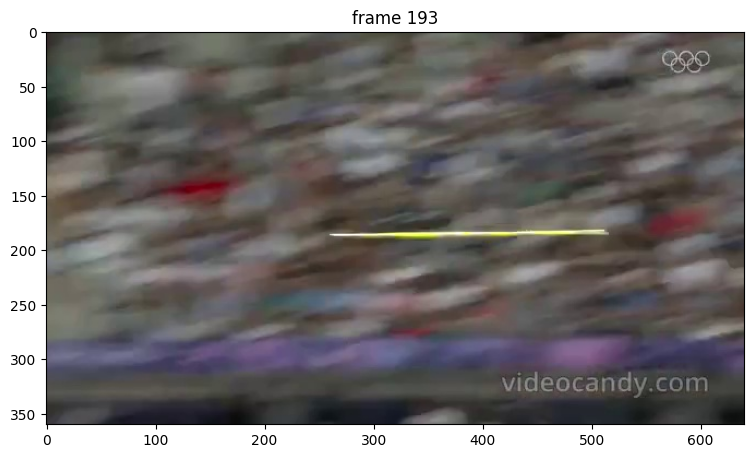

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt

video_dir = '/content/video_frames'
frame_names = sorted(os.listdir(video_dir))
ann_frame_idx = 193

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))

In [23]:
import numpy as np

points = np.array([[400, 183]], dtype=np.float32)
labels = np.array([1])
frame_idx = 193
tracker_id = 1

frame_ids, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id,
    points=points,
    labels=labels,
)

print(frame_ids)
print(object_ids)
print(mask_logits)

193
[1, 2]
tensor([[[[  -11.6955,   -11.8800,   -12.6182,  ...,   -15.3706,
             -16.5536,   -16.8493],
          [  -12.5826,   -12.6549,   -12.9441,  ...,   -15.4745,
             -14.9432,   -14.8104],
          [  -13.4058,   -13.3135,   -12.9444,  ...,   -15.7332,
             -14.5587,   -14.2651],
          ...,
          [  -13.3764,   -13.1323,   -12.1561,  ...,   -15.4506,
             -15.2416,   -15.1894],
          [  -12.1109,   -12.0132,   -11.6223,  ...,   -15.0585,
             -14.7244,   -14.6409],
          [  -11.1876,   -11.3148,   -11.8235,  ...,   -14.2827,
             -12.9952,   -12.6734]]],


        [[[-1024.0000, -1024.0000, -1024.0000,  ..., -1024.0000,
           -1024.0000, -1024.0000],
          [-1024.0000, -1024.0000, -1024.0000,  ..., -1024.0000,
           -1024.0000, -1024.0000],
          [-1024.0000, -1024.0000, -1024.0000,  ..., -1024.0000,
           -1024.0000, -1024.0000],
          ...,
          [-1024.0000, -1024.0000, -1024.0000,

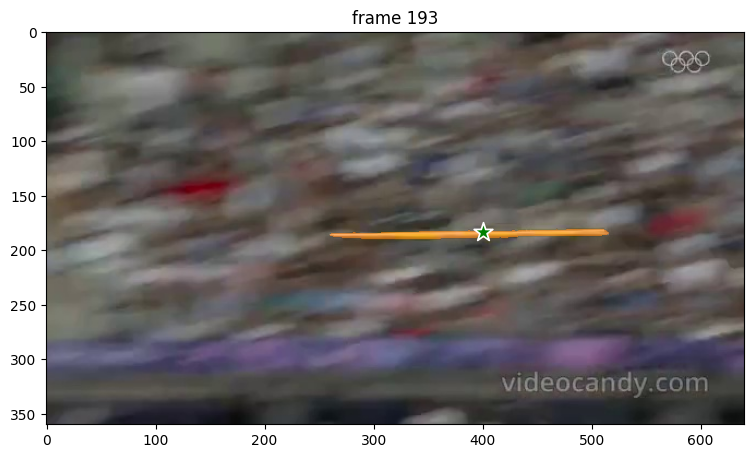

In [24]:
from PIL import Image
import os

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=object_ids[0])

## Person

In [14]:
import numpy as np

points = np.array([[200, 250]], dtype=np.float32)
labels = np.array([1])
frame_idx = 0
tracker_id = 2

frame_ids, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id,
    points=points,
    labels=labels,
)

print(frame_ids)
print(object_ids)
print(mask_logits)

0
[1, 2]
tensor([[[[-12.5868, -12.6929, -13.1173,  ..., -12.6869, -13.1485, -13.2639],
          [-13.3867, -13.2748, -12.8274,  ..., -12.6647, -12.2939, -12.2013],
          [-13.5325, -13.2972, -12.3564,  ..., -12.8249, -12.0831, -11.8977],
          ...,
          [ -9.8386,  -9.7236,  -9.2640,  ..., -15.4029, -14.9207, -14.8001],
          [ -9.4261,  -9.3515,  -9.0532,  ..., -14.8759, -14.3945, -14.2741],
          [ -9.1236,  -9.0869,  -8.9399,  ..., -13.8231, -13.2461, -13.1018]]],


        [[[-10.7828, -10.8623, -11.1803,  ..., -11.3188, -11.8525, -11.9859],
          [-11.1312, -11.0674, -10.8120,  ..., -10.8477, -10.6014, -10.5398],
          [-10.9439, -10.7924, -10.1862,  ..., -10.7835, -10.2925, -10.1698],
          ...,
          [  2.1993,   2.2372,   2.3888,  ..., -10.1002,  -9.8848,  -9.8310],
          [  1.8878,   1.9312,   2.1050,  ...,  -9.7921,  -9.5133,  -9.4436],
          [  1.4230,   1.4534,   1.5753,  ...,  -9.2839,  -8.5662,  -8.3868]]]],
       device='cud

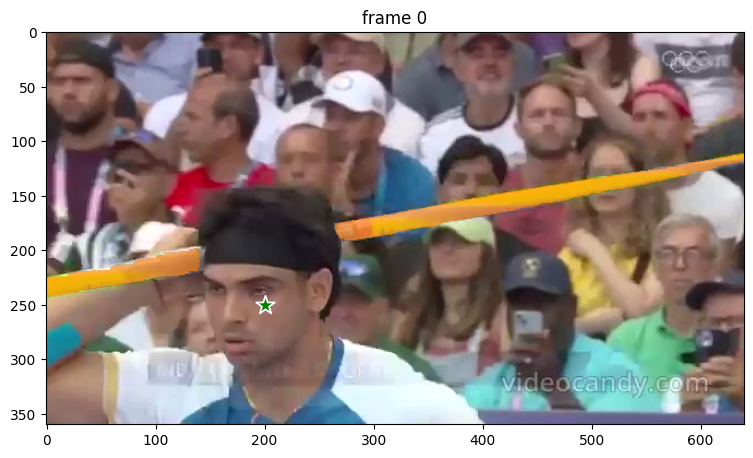

In [15]:
from PIL import Image
import os

plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=object_ids[0])

## Segmenting across the complete video

In [25]:
import cv2
import supervision as sv

colors = ['#FF1493', '#00BFFF']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    color_lookup=sv.ColorLookup.TRACK)

video_info = sv.VideoInfo.from_video_path('/content/videoplayback_trimmed.mp4')
frames_paths = sorted(sv.list_files_with_extensions(
    directory='/content/video_frames',
    extensions=["jpeg"]))

with sv.VideoSink('/content/new_video.mp4', video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame = cv2.imread(frames_paths[frame_idx])
        masks = (mask_logits > 0.0).cpu().numpy()
        N, X, H, W = masks.shape
        masks = masks.reshape(N * X, H, W)
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=np.array(object_ids)
        )
        frame = mask_annotator.annotate(frame, detections)
        sink.write_frame(frame)

propagate in video: 100%|██████████| 233/233 [04:54<00:00,  1.27s/it]


In [26]:
from google.colab import files
files.download('/content/new_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>